Fig. 5: FateID fate bias
---

In this notebook, we plot the FateID's fate bias. In order to reproduce the smoothed gene trends, please refer to
[MK_2020-17-10_plot_trends.ipynb](MK_2020-17-10_plot_trends.ipynb).

# Preliminaries

## Dependency notebooks

1. [analysis_notebooks/MK_2020-17-10_extract_fate_bias.ipynb](analysis_notebooks/MK_2020-17-10_extract_fate_bias.ipynb)

## Import packages

In [1]:
# import standard packages
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import single-cell packages
import scanpy as sc
import scvelo as scv
import cellrank as cr

# import CellRank utilities
from cellrank.tl import Lineage
from cellrank.tl._utils import _fuzzy_to_discrete, _series_from_one_hot_matrix
from cellrank.tl._colors import _colors_in_order

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

In [2]:
cr.logging.print_versions()

cellrank==1.0.0-rc.12 scanpy==1.6.0 anndata==0.7.4 numpy==1.19.2 numba==0.51.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.2 scvelo==0.2.2 pygam==0.8.0 matplotlib==3.3.2 seaborn==0.11.0


## Set up paths

In [3]:
sys.path.insert(0, "../../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

In [4]:
root_fig= FIG_DIR / "fig_5_benchmarking" / "fateid"

scv.settings.figdir = str(root_fig)
sc.settings.figdir = str(root_fig)
cr.settings.figdir = str(root_fig)

## Set global parameters

In [5]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=16, color_map='viridis')
scv.settings.plot_prefix = ""

save_figure = True

## Load the data

In [6]:
adata = cr.read(DATA_DIR / "pancreas" / "pancreas.h5ad")

probs = pd.read_csv(DATA_DIR / "benchmarking" / "fateid" / "probs.csv", index_col=0)
probs.columns = ['Beta', 'Alpha', 'Epsilon', 'Delta']

adata.obsm['to_terminal_states'] = cr.tl.Lineage(probs.values, names=probs.columns)

# Plot the results

## Plot terminal states

These are not provided by FateID, at least not without prior knowledge about genes that mark mature populations. Therefore, we just return a grey umap:

saving figure to file /home/icb/marius.lange/python_projects/cellrank_reproducibility/figures/fig_5_benchmarking/fateid/final_states.pdf


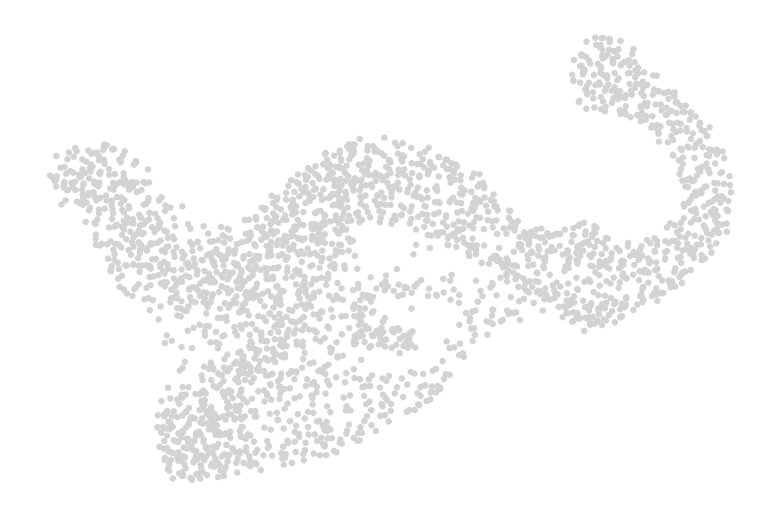

In [7]:
figure_kwargs = {'color': '#D3D3D3'}
if save_figure: figure_kwargs['save'] = 'final_states'
scv.pl.scatter(adata, **figure_kwargs)

## Plot fate map in multiple plots

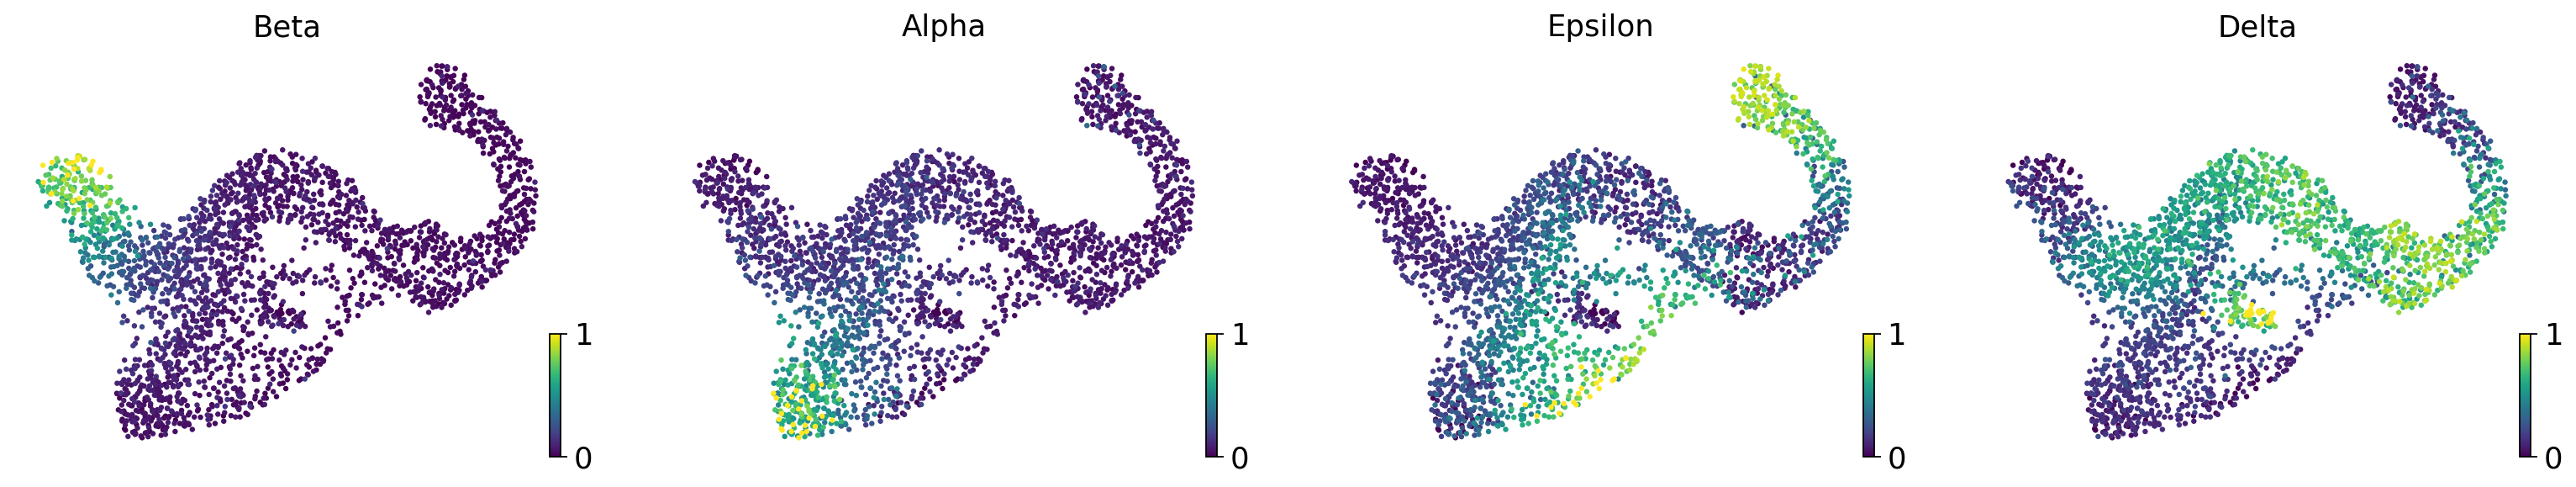

In [8]:
# look at individual fate vectors
fate_probs = adata.obsm['to_terminal_states']
scv.pl.scatter(adata, color=[a for a in fate_probs.X.T], color_map='viridis', title=['Beta', 'Alpha', 'Epsilon', 'Delta'])

## Plot fate map in one plot

saving figure to file /home/icb/marius.lange/python_projects/cellrank_reproducibility/figures/fig_5_benchmarking/fateid/cell_fate_map.pdf


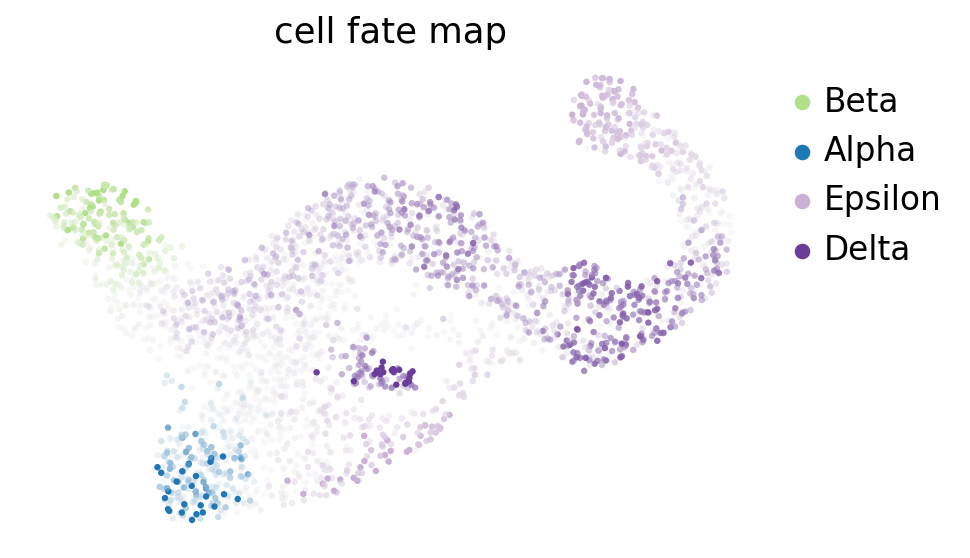

In [9]:
# put branch probs into lineage object, assign names and colors
X = fate_probs
names = ['Beta', 'Alpha', 'Epsilon', 'Delta']
colors = _colors_in_order(adata, clusters=names)
L = Lineage(X, names=names, colors=colors)

# from each state, select the most likely cells and save in adata
D, _ = _fuzzy_to_discrete(L, n_most_likely=30, check_row_sums=False)
adata.obs['terminal_states'] = _series_from_one_hot_matrix(D, index=adata.obs_names, names=L.names)
adata.uns['terminal_states_colors'] = L.colors
adata.uns['to_terminal_states_colors'] = L.colors
adata.obsm['to_terminal_states'] = L

figure_kwargs = {'title': 'cell fate map'}
if save_figure:
    figure_kwargs['save'] = 'cell_fate_map'
    
scv.pl.scatter(adata, color='terminal_states', color_gradients='to_terminal_states', **figure_kwargs)

## Plot heatmap over Fev+ subclustering

In [10]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=18)

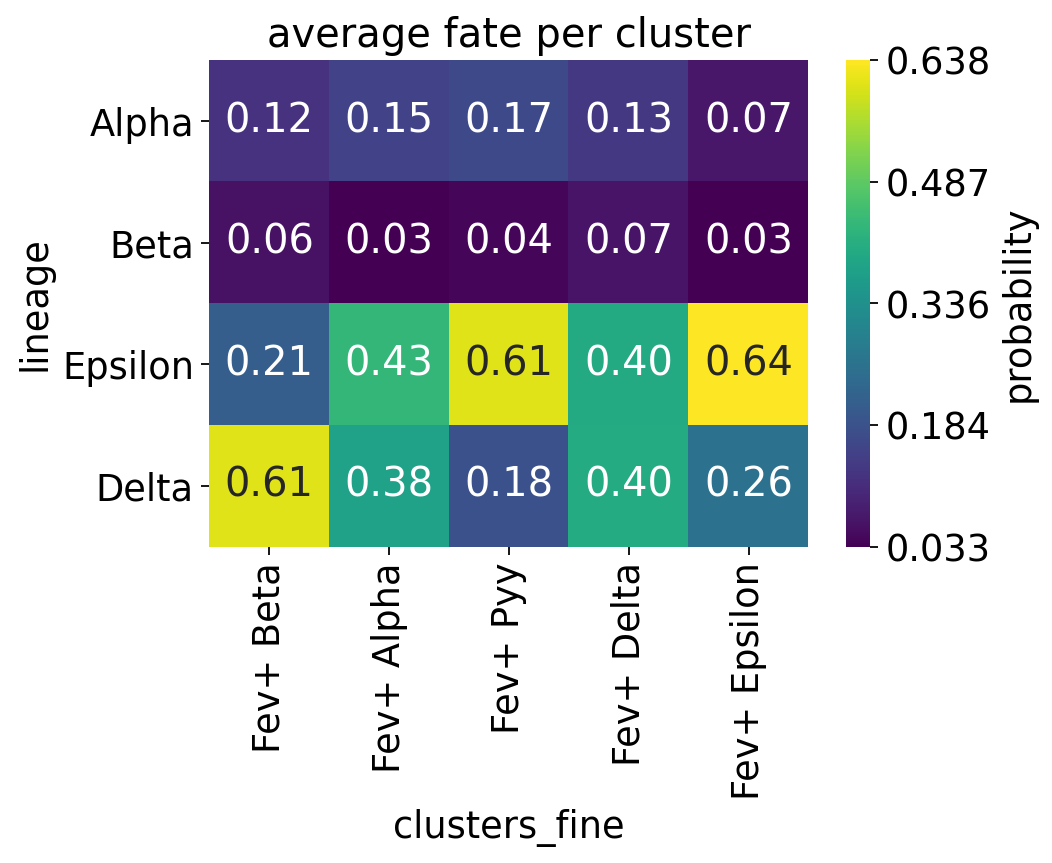

In [11]:
figure_kwargs = {'cluster_key': 'clusters_fine', 'mode': 'heatmap', 
                 'lineages': ['Alpha', 'Beta', 'Epsilon', 'Delta'],
                'clusters': ['Fev+ Beta', 'Fev+ Alpha', 'Fev+ Pyy', 'Fev+ Delta', 'Fev+ Epsilon']}
if save_figure:
    figure_kwargs['save'] = 'fateid_heatmap'
    
cr.pl.cluster_fates(adata, **figure_kwargs, )

## Plot heatmap over only Ngn3 high EP

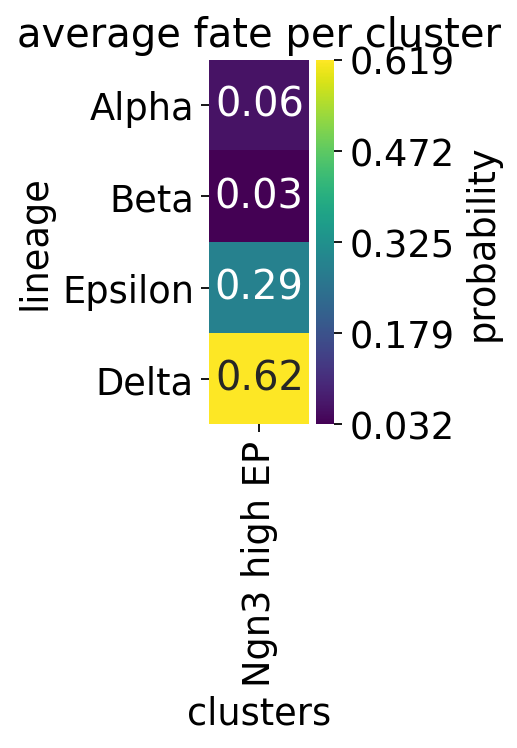

In [12]:
figure_kwargs = {'cluster_key': 'clusters', 'mode': 'heatmap', 
                 'lineages': ['Alpha', 'Beta', 'Epsilon', 'Delta'],
                'clusters': ['Ngn3 high EP'], 'figsize': (1, 3)}
if save_figure:
    figure_kwargs['save'] = 'palantir_heatmap_ngn3_high.pdf'
    
cr.pl.cluster_fates(adata, **figure_kwargs)